In [1]:
import matplotlib.pyplot as plt

# 데이터 가져오기

In [25]:
import ccxt
import pandas as pd
import time

def fetch_ohlcv_all(exchange, symbol, timeframe, start_iso, end_iso=None, limit=1000, pause=0.2):
    """
    start_iso/end_iso: '2023-01-01T00:00:00Z' 같은 ISO 문자열
    end_iso가 None이면 가능한 데까지 가져옴
    """
    since = exchange.parse8601(start_iso)
    end_ms = exchange.parse8601(end_iso) if end_iso else None

    all_rows = []
    while True:
        rows = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)

        if not rows:
            break

        # 중복 방지: 같은 timestamp가 들어오면 제거
        if all_rows and rows[0][0] <= all_rows[-1][0]:
            rows = [r for r in rows if r[0] > all_rows[-1][0]]
            if not rows:
                break

        all_rows.extend(rows)
        since = all_rows[-1][0] + 1

        if end_ms and all_rows[-1][0] >= end_ms:
            break

        time.sleep(pause)  # 레이트리밋/차단 방지

    df = pd.DataFrame(all_rows, columns=["timestamp", "open", "high", "low", "close", "volume"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True).dt.tz_convert("Asia/Seoul")
    df = df.set_index("date").drop(columns=["timestamp"])
    return df

exchange = ccxt.binance({"enableRateLimit": True})

symbol = "USDC/USDT"
timeframe = "1h"

df = fetch_ohlcv_all(
    exchange,
    symbol=symbol,
    timeframe=timeframe,
    start_iso="2022-01-01T00:00:00Z",
    end_iso="2026-02-09T00:00:00Z",
    limit=1000,
    pause=0.25
)

print(df.shape)


(32007, 5)


In [26]:
csv_path = "USDC_USDT_1h_ohlcv.csv"
df.to_csv(csv_path)

## 디페깅 이벤트 감지

In [27]:
df["depeg_close_abs"] = (df["close"] - 1.0).abs()
df["depeg_low_under1"] = (1.0 - df["low"]).clip(lower=0)

THRESHOLD = 0.005  # 0.5%

df["is_depeg"] = df["depeg_close_abs"] >= THRESHOLD

df[df["is_depeg"]][["open","high","low","close","depeg_close_abs"]].head(10)

,open,high,low,close,depeg_close_abs
date,,,,,
2022-05-12 05:00:00+09:00,1.0029,3.9900,1.0029,1.0051,0.0051
2022-05-12 08:00:00+09:00,1.0045,1.0089,1.0040,1.0060,0.0060
2022-05-12 11:00:00+09:00,1.0044,1.0053,1.0040,1.0051,0.0051
2022-05-12 12:00:00+09:00,1.0051,1.0100,1.0047,1.0065,0.0065
2022-05-12 13:00:00+09:00,1.0065,1.0111,1.0058,1.0067,0.0067
2022-05-12 14:00:00+09:00,1.0067,1.0350,1.0064,1.0195,0.0195
2022-05-12 15:00:00+09:00,1.0194,1.0650,1.0187,1.0500,0.0500
2022-05-12 16:00:00+09:00,1.0503,1.1383,1.0150,1.0203,0.0203
2022-05-12 17:00:00+09:00,1.0203,1.0266,1.0130,1.0221,0.0221


In [28]:
# True/False가 바뀌는 지점에 이벤트 ID 부여
df["event_id"] = (df["is_depeg"] != df["is_depeg"].shift()).cumsum()

# 디페깅 구간만 필터
events = df[df["is_depeg"]].groupby("event_id").agg(
    start_time = ("close", lambda x: x.index.min()),
    end_time   = ("close", lambda x: x.index.max()),
    duration_hours = ("close", "count"),
    max_depeg_close = ("depeg_close_abs", "max"),
    min_low = ("low", "min"),
    avg_volume = ("volume", "mean")
)

events = events.sort_values("max_depeg_close", ascending=False)
events.head(10)


,start_time,end_time,duration_hours,max_depeg_close,min_low,avg_volume
event_id,,,,,,
8,2023-03-11 23:00:00+09:00,2023-03-14 01:00:00+09:00,51,0.0872,0.8820,4.963654e+07
6,2022-05-12 11:00:00+09:00,2022-05-12 22:00:00+09:00,12,0.0500,1.0040,1.532749e+08
12,2023-03-14 08:00:00+09:00,2023-03-14 23:00:00+09:00,16,0.0066,0.9929,2.572063e+07
14,2023-03-15 11:00:00+09:00,2023-03-15 21:00:00+09:00,11,0.0065,0.9931,4.084569e+07
4,2022-05-12 08:00:00+09:00,2022-05-12 08:00:00+09:00,1,0.0060,1.0040,6.422209e+07
10,2023-03-14 05:00:00+09:00,2023-03-14 06:00:00+09:00,2,0.0054,0.9942,1.659766e+07
2,2022-05-12 05:00:00+09:00,2022-05-12 05:00:00+09:00,1,0.0051,1.0029,1.347269e+08


In [29]:
events_filtered = events[
    (events["duration_hours"] >= 3) |      # 최소 3시간 지속
    (events["max_depeg_close"] >= 0.01)     # 또는 1% 이상 이탈
]

events_filtered

,start_time,end_time,duration_hours,max_depeg_close,min_low,avg_volume
event_id,,,,,,
8,2023-03-11 23:00:00+09:00,2023-03-14 01:00:00+09:00,51,0.0872,0.8820,4.963654e+07
6,2022-05-12 11:00:00+09:00,2022-05-12 22:00:00+09:00,12,0.0500,1.0040,1.532749e+08
12,2023-03-14 08:00:00+09:00,2023-03-14 23:00:00+09:00,16,0.0066,0.9929,2.572063e+07
14,2023-03-15 11:00:00+09:00,2023-03-15 21:00:00+09:00,11,0.0065,0.9931,4.084569e+07


In [30]:
#csv 저장
events_filtered.to_csv("USDC_depeg_events.csv")

# 기타

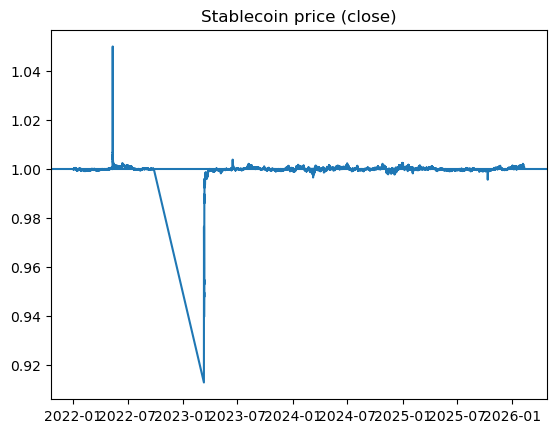

In [31]:
plt.figure()
plt.plot(df.index, df["close"])
plt.axhline(1.0)
plt.title("Stablecoin price (close)")
plt.show()